In [7]:
pip install scipy

  Using cached scipy-1.14.1.tar.gz (58.6 MB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... error
  error: subprocess-exited-with-error
  
  × Preparing metadata (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [49 lines of output]
      + meson setup /private/var/folders/ln/c_qknrr51xbgxcyyp59605kr0000gn/T/pip-install-xodrgobq/scipy_f23349f210a54648854a6ebaacbb8025 /private/var/folders/ln/c_qknrr51xbgxcyyp59605kr0000gn/T/pip-install-xodrgobq/scipy_f23349f210a54648854a6ebaacbb8025/.mesonpy-c5tvuqgm -Dbuildtype=release -Db_ndebug=if-release -Db_vscrt=md --native-file=/private/var/folders/ln/c_qknrr51xbgxcyyp59605kr0000gn/T/pip-install-xodrgobq/scipy_f23349f210a54648854a6ebaacbb8025/.mesonpy-c5tvuqgm/meson-python-native-file.ini
      The Meson build system
      Version: 1.6.0
      Source dir: /private/var/folders/ln/c_qknrr51xbgxcyyp59605kr0000gn/T/pip-install-xodrgobq/scipy_f23349f210a

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import expm
def drive_H(rabi_frequency,detuning):
    return np.array([[0.5*detuning,0.5*rabi_frequency],[0.5*rabi_frequency,-0.5*detuning]])


rabi_frequency = 2*np.pi*(1/0.0478e-3)/4 # From RbCs Ramsey Paper https://doi.org/10.1088/2058-9565/aaee35 Figure 7
print(rabi_frequency)
detunings = 2*np.pi*np.linspace(-15,15,1000) # note 2pi. This is  -15 -> 15 kHz 
pulse_time = 0.0478 # in ms
print((pulse_time*rabi_frequency)/(np.pi/2)) # Check pulse time and rabi frequency give a pi/2 pulse area 

free_time = 0.6 # in ms

populations = []
for detuning in detunings:
    psi_0 = np.array([1,0])

    H_pulse = drive_H(rabi_frequency,detuning)
    psi_after_pulse1 = expm(-1j*H_pulse*pulse_time)@psi_0 # @ for matrix multiplication
    H_free = drive_H(0,detuning) # zero Rabi Frequency but still need detuning in H 
    psi_after_free = expm(-1j*H_free*free_time)@psi_after_pulse1
    psi_after_pulse2 = expm(-1j*H_pulse*pulse_time)@psi_after_free
    populations.append(np.abs(psi_after_pulse2[0])**2)

plt.plot(np.array(detunings)/(2*np.pi),populations)
plt.ylabel("Population")
plt.xlabel("Detuning (kHz)")
plt.show()

ModuleNotFoundError: No module named 'scipy'

In [ ]:
def drive_H(rabi_frequency, detuning, phase):
    return np.array([[0.5*detuning,0.5*rabi_frequency*np.exp(1j*phase)],[0.5*rabi_frequency*np.exp(-1j*phase),-0.5*detuning]])

def H_int(J):
    return np.array([[0, 0, 0, 0], [0, 0,  J/2.0, 0], [0, J/2.0, 0, 0], [0, 0, 0, 0]])

def full_laser(size, no_states, rabi_frequency, detuning, phase):
    #Create Hamiltonian for laser
    H_pulse = np.zeros((no_states, no_states))
    for i in range(size):
        particle_pulse = [1]
        for _ in range(size - i - 1):
            particle_pulse = np.kron(particle_pulse, np.eye(2))
        particle_pulse = np.kron(particle_pulse, drive_H(rabi_frequency, detuning, phase))
        for _ in range(i):
            particle_pulse = np.kron(particle_pulse, np.eye(2))
        H_pulse = H_pulse + particle_pulse
    return H_pulse

def total_H_int(size, no_states, J):
    #Create Hamiltonian for interaction
    H_pulse = np.zeros((no_states, no_states))
    for i in range(size - 1):
        particle_pulse = [1]
        for _ in range(size - i - 2):
            particle_pulse = np.kron(particle_pulse, np.eye(2))
        particle_pulse = np.kron(particle_pulse, H_int(J))
        for _ in range(i):
            particle_pulse = np.kron(particle_pulse, np.eye(2))
        H_pulse = H_pulse + particle_pulse
    return H_pulse

def simulate(size, params, J):
    no_states = 2**size
    psi_0 = np.zeros(no_states)
    psi_0[0] = 1  #all spins down


    interaction = total_H_int(size, no_states, J)

    #Create Hamiltonian for laser 1
    H_pulse1 = full_laser(size, no_states, params['rabi_frequency'], params['detuning'], 0) + interaction
    #evolve for 1st pulse
    psi_after_pulse1 = expm(-1j*H_pulse1*params['pulse_time'])@psi_0 # @ for matrix multiplication
    
    #Create Hamiltonian for free evolution
    H_free = full_laser(size, no_states, 0, params['detuning'], 0) + interaction
    #evolve for free evolution
    psi_after_free = expm(-1j*H_free*params['hold'])@psi_after_pulse1
    
    #Create Hamiltonian for laser 2
    H_pulse2 = full_laser(size, no_states, params['rabi_frequency'], params['detuning'], params['phase']) + interaction
    #evolve for 2nd pulse
    psi_after_pulse2 = expm(-1j*H_pulse2*pulse_time)@psi_after_free
    #print(expm(-1j*H_pulse2*pulse_time))
    
    return psi_after_pulse2

def Ramsey(size, params, dep_var, values, interact=True):
    populations = []
    
    if interact == True:   #sample J in gaussian distribution
        J = np.random.normal(5, 0.1)
    else:
        J = 0
        
    #simulate system for each dependant variable value
    for i in values:
        params[dep_var] = i
        final_state = simulate(size, params, J)
        populations.append(np.abs(final_state)**2)
    return np.array(populations)

def str_tens(A, B):
    new = []
    for i in A:
        for n in B:
            new.append(i + n)
    return new

def Ramsey_plot(size, populations, values, dep_var):
    basis = [r'0', r'1']
    labels = [r'0', r'1']
    for i in range(size - 1):
        labels = str_tens(labels, basis)
        
    fig, axes = plt.subplots(1, 1)
    for i in range(len(populations[0])):
        axes.plot(values, populations[:,i], label='|' + labels[i] + r'$\rangle$')
        
    #for i in range(5):
        #print(populations[:,1][100*i])

    axes.set_ylabel("Population", fontsize=20)
    axes.set_xlabel(dep_var, fontsize=20)
    axes.legend(loc=4)
    plt.show

def Ramsey_plot_ensemble(size, populations, values, dep_var, fig, axes):
    basis = [r'0', r'1']
    labels = [r'0', r'1']
    for i in range(size - 1):
        labels = str_tens(labels, basis)
        
    for i in range(len(populations[0])):
        axes.plot(values, populations[:,i], label='|' + labels[i] + r'$\rangle$')
        
    #for i in range(5):
        #print(populations[:,1][100*i])

In [ ]:
holds = np.linspace(0,15,1000)
phases = 2*np.pi*np.linspace(-0.5,0.5,1000)


rel_phase = 0
particle_number = 1
dep_var = 'hold'
dep_var_values = holds

if dep_var == 'phase':
    detuning = 0
else:
    detuning = 0.5
    
args = {'pulse_time': pulse_time, 'hold': free_time, 'detuning': detuning, 'phase': rel_phase, 'rabi_frequency': rabi_frequency}

pop = Ramsey(particle_number, args, dep_var, dep_var_values)
Ramsey_plot(particle_number, pop, dep_var_values, dep_var)

In [5]:
rel_phase = 0
particle_number = 1
dep_var = 'hold'
dep_var_values = holds

if dep_var == 'phase':
    detuning = 0
else:
    detuning = 0.5


detuning = 0
args = {'pulse_time': pulse_time, 'hold': free_time, 'detuning': detuning, 'phase': rel_phase, 'rabi_frequency': rabi_frequency}

particle_number = 2

fig, axes = plt.subplots(1, 1)
rol_avg = []
for i in range(5):
    pop = Ramsey(particle_number, args, dep_var, dep_var_values, interact=True)
    Ramsey_plot_ensemble(particle_number, pop, dep_var_values, dep_var, fig, axes)
    rol_avg.append(pop)

#average = np.mean(np.array(rol_avg), axis=0)

axes.plot(dep_var_values, average)
axes.set_ylabel("Population", fontsize=20)

axes.set_xlabel(dep_var, fontsize=20)
plt.show

NameError: name 'holds' is not defined

0.00023045642811497357
0.10477169654799652
0.252442793042558
0.15672343214265688
0.0033405421424157022


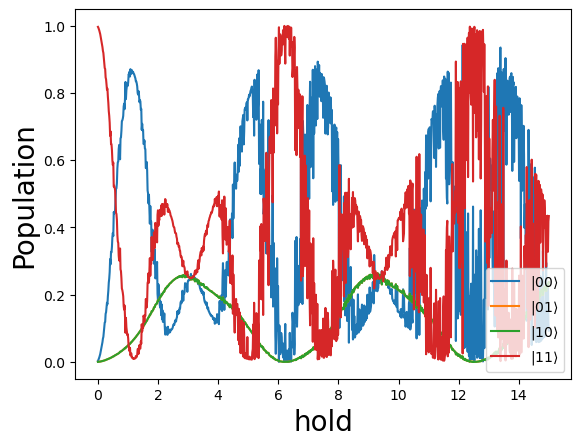

In [420]:
particle_number = 2

pop = Ramsey(particle_number, args, dep_var, dep_var_values)
Ramsey_plot(particle_number, pop, dep_var_values, dep_var)

0.003250221431106355
0.054048370959327345
0.08133419781650647
0.022434741287969937
0.004690609276886488


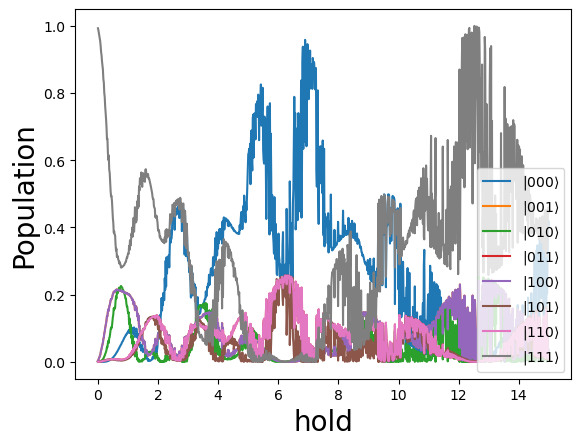

In [423]:
particle_number = 3

pop = Ramsey(particle_number, args, dep_var, dep_var_values)
Ramsey_plot(particle_number, pop, dep_var_values, dep_var)

0.00023131898039605836
6.265963352818147e-11
0.0006063564104183426
6.402587037621981e-10
0.0011571923360800625


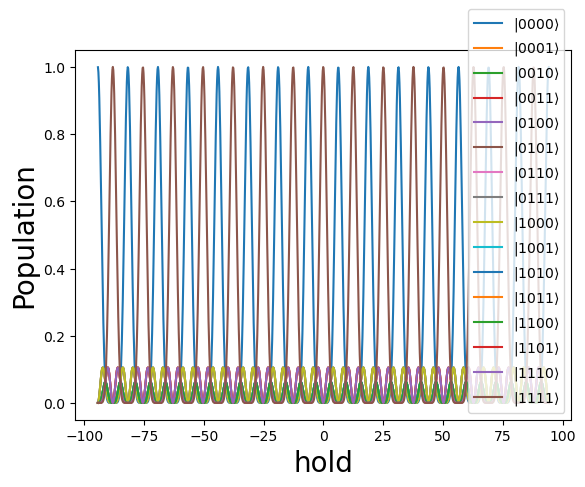

In [427]:
particle_number = 4

pop = Ramsey(particle_number, args, dep_var, detunings, interact=False)
Ramsey_plot(particle_number, pop, detunings, dep_var)

In [25]:
A = np.ones(2)
print(A)
labels, ket = [r'$\downarrow$', r'$\uparrow$'], [r'$\downarrow$', r'$\uparrow$']


print(new)

[1. 1.]
['$\\downarrow$$\\downarrow$', '$\\downarrow$$\\uparrow$', '$\\uparrow$$\\downarrow$', '$\\uparrow$$\\uparrow$']


In [195]:
print(full_laser(2, 2**2, rabi_frequency, detuning, 0))

[[ 0.5+0.j  0. +0.j  0. +0.j  0. +0.j]
 [ 0. +0.j  0. +0.j  0. +0.j  0. +0.j]
 [ 0. +0.j  0. +0.j  0. +0.j  0. +0.j]
 [ 0. +0.j  0. +0.j  0. +0.j -0.5+0.j]]


In [233]:
print(H_int(2, 4, 2))

[[0. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 0.]]


In [387]:

simulate(2, args)

94.24777960769379
3.8798162350056646
[[ 94.24777961+0.j  16.43092392+0.j  16.43092392+0.j   0.        +0.j]
 [ 16.43092392+0.j   0.        +0.j   1.93990812+0.j  16.43092392+0.j]
 [ 16.43092392+0.j   1.93990812+0.j   0.        +0.j  16.43092392+0.j]
 [  0.        +0.j  16.43092392+0.j  16.43092392+0.j -94.24777961+0.j]]


array([-0.96544579+0.19424047j, -0.08361723+0.05352637j,
       -0.08361723+0.05352637j, -0.04206485+0.0932834j ])

In [333]:
print(np.random.normal(5, 1))

5.0282198018541235


0.10802365474918033
0.35348130148767776
0.6735918454228332
0.9044290590663389
0.9876559444943427


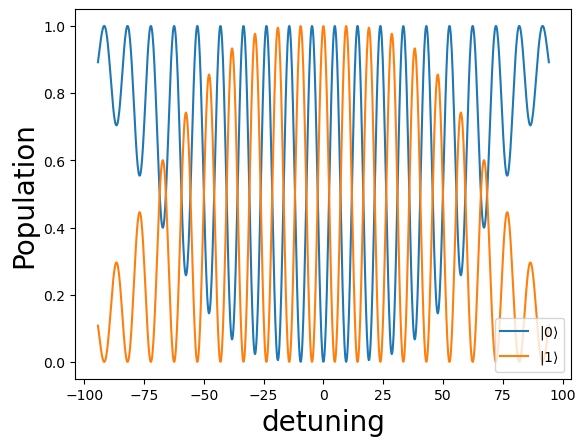

In [431]:
holds = np.linspace(0,15,1000)
phases = 2*np.pi*np.linspace(-0.5,0.5,1000)


rel_phase = 0
particle_number = 1
dep_var = 'detuning'
dep_var_values = detunings

if dep_var == 'phase':
    detuning = 0
else:
    detuning = 0.5
    
args = {'pulse_time': pulse_time, 'hold': free_time, 'detuning': detuning, 'phase': rel_phase, 'rabi_frequency': rabi_frequency}

pop = Ramsey(particle_number, args, dep_var, dep_var_values)
Ramsey_plot(particle_number, pop, dep_var_values, dep_var)

In [ ]:
particle_number = 2



0.09635454476381038
0.2285322709862551
0.219865871202695
0.08643713618271608
0.012191679799331097


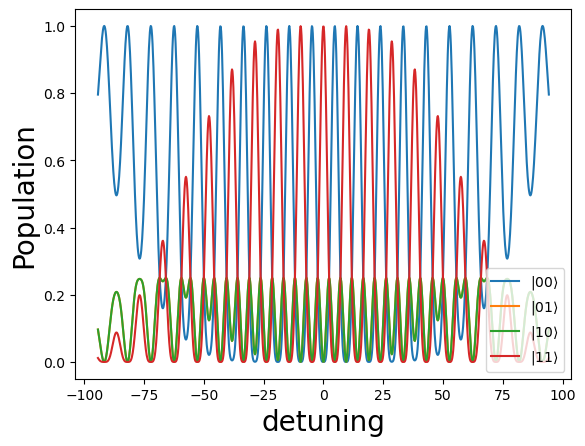

In [437]:
particle_number = 2

pop = Ramsey(particle_number, args, dep_var, dep_var_values, interact=False)
Ramsey_plot(particle_number, pop, dep_var_values, dep_var)

0.08594597468672939
0.147750386406099
0.07176601327377276
0.008260878436593231
0.00015049477215014925


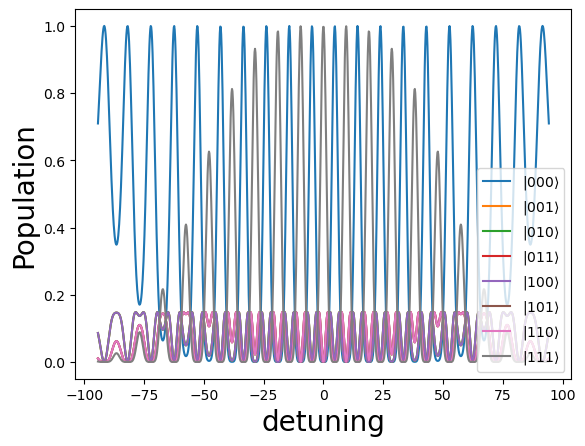

In [439]:
particle_number = 3

pop = Ramsey(particle_number, args, dep_var, dep_var_values, interact=False)
Ramsey_plot(particle_number, pop, dep_var_values, dep_var)

6.83088736767422e-33
0.0865224473729215
0.22631164710128643
0.22584914035629056
0.08577520258599022


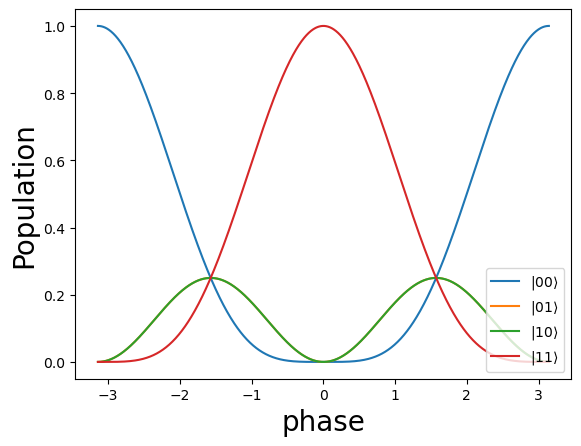

In [443]:

holds = np.linspace(0,15,1000)
phases = 2*np.pi*np.linspace(-0.5,0.5,1000)


rel_phase = 0
particle_number = 1
dep_var = 'phase'
dep_var_values = phases

if dep_var == 'phase':
    detuning = 0
else:
    detuning = 0.5
    
args = {'pulse_time': pulse_time, 'hold': free_time, 'detuning': detuning, 'phase': rel_phase, 'rabi_frequency': rabi_frequency}

particle_number = 2

pop = Ramsey(particle_number, args, dep_var, dep_var_values, interact=False)
Ramsey_plot(particle_number, pop, dep_var_values, dep_var)

<function matplotlib.pyplot.show(close=None, block=None)>

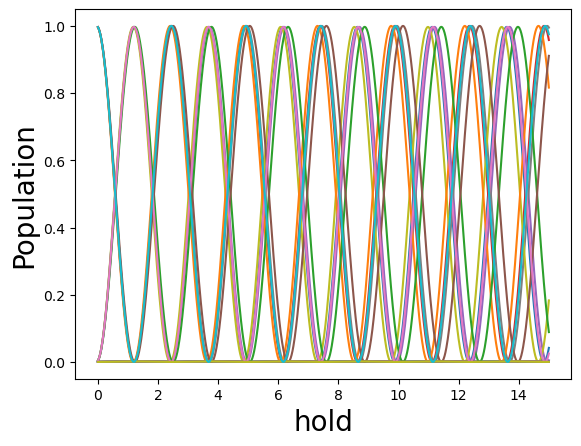

In [475]:
rel_phase = 0
particle_number = 1
dep_var = 'hold'
dep_var_values = holds

if dep_var == 'phase':
    detuning = 0
else:
    detuning = 0.5


detuning = 0
args = {'pulse_time': pulse_time, 'hold': free_time, 'detuning': detuning, 'phase': rel_phase, 'rabi_frequency': rabi_frequency}

particle_number = 2

fig, axes = plt.subplots(1, 1)
for i in range(5):
    pop = Ramsey(particle_number, args, dep_var, dep_var_values, interact=True)
    Ramsey_plot_ensemble(particle_number, pop, dep_var_values, dep_var, fig, axes)
axes.set_ylabel("Population", fontsize=20)
axes.set_xlabel(dep_var, fontsize=20)
plt.show

5.357158658024362e-08
0.01796700632720421
0.11996175003398593
0.11846612187068875
0.0029047241703005935


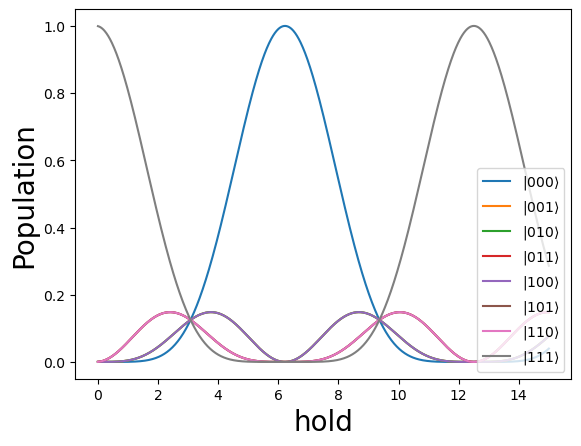

In [449]:
rel_phase = 0
particle_number = 1
dep_var = 'hold'
dep_var_values = holds

if dep_var == 'phase':
    detuning = 0
else:
    detuning = 0.5
    
args = {'pulse_time': pulse_time, 'hold': free_time, 'detuning': detuning, 'phase': rel_phase, 'rabi_frequency': rabi_frequency}

particle_number = 3

pop = Ramsey(particle_number, args, dep_var, dep_var_values, interact=False)
Ramsey_plot(particle_number, pop, dep_var_values, dep_var)

In [11]:
rabi_frequency = 2*np.pi*(1/0.0478e-3)/4 # From RbCs Ramsey Paper https://doi.org/10.1088/2058-9565/aaee35 Figure 7
print(rabi_frequency)

32861.84784089741
